# pyTao advanced usage

In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,8)
%config InlineBackend.figure_format = 'retina'

In [2]:
from pytao import Tao, TaoModel, util, run_tao
from pytao.tao_ctypes.evaluate import evaluate_tao
import os
?TaoModel

Init signature:
TaoModel(
    input_file='tao.init',
    ploton=True,
    use_tempdir=True,
    workdir=None,
    verbose=True,
    so_lib='',
    auto_configure=True,
)
Docstring:     
Base class for setting up a Tao model in a directory. Builds upon the Tao class.

If use_tempdir==True, then the input_file and its directory will be copied to a temporary directory.
If workdir is given, then this temporary directory will be placed in workdir.
File:           ~/Code/bmad_svn/tao/python/pytao/tao_ctypes/core.py
Type:           type
Subclasses:     


## Inititialize Tao

In [3]:
# Point to local installation
BASE_DIR=os.environ['ACC_ROOT_DIR'] 
print('Bmad installation: ', BASE_DIR)

# Pick an example init
root = BASE_DIR+'tao/examples/csr_beam_tracking/'

INPUT_FILE = root+'tao.init'
assert os.path.exists(INPUT_FILE), INPUT_FILE

Bmad installation:  /Users/chrisonian/Code/bmad_svn/


# run_tao

In [4]:
M=run_tao(input_file=INPUT_FILE, ploton=True)
M

# evaluate_tao

In [5]:
?evaluate_tao

Signature:
evaluate_tao(
    settings,
    run_commands=['set global track_type=beam'],
    expressions=['lat::orbit.x[end]'],
    input_file=None,
    ploton=False,
    beam_archive_path=None,
    archive_csr_wake=False,
    workdir=None,
    so_lib='',
    verbose=False,
)
Docstring:
settings: dict of set_command:value where set_command is a string.
    Example:
        'global:track_type':'beam'
            will issue command:
        set global track_type = beam

run_commands: list of command strings that will be executed.

expressions: list of expression strings that will be used to form the output.

beam_archive_path: if given, the all of the saved beams will be written to
    a file named by a fingerprint (hash) of the inputs into path beam_archive_path.
    This uses the command:
        write beam -at *
    which writes ALL of the bunches that are saved using the beam_saved_at list in beam_init.
    
archive_csr_wake: if given, will look for csr_wake.dat, parse, and archive to

In [6]:
res = evaluate_tao(settings={'csr_param:write_csr_wake':True,
                            'csr_param:ds_track_step':0.001}, 
                   input_file=root+'tao.init', 
                   run_commands=['set global track_type=beam'],
                   expressions = ['lat::orbit.x[FF.PIP02A]', 'beam::norm_emit.x[end]'],
                   ploton=False, 
                   archive_csr_wake=True,
                   beam_archive_path = '.')
res

{'lat::orbit.x[FF.PIP02A]': 0.0,
 'beam::norm_emit.x[end]': 9.9982316502565e-07,
 'beam_archive': '/Users/chrisonian/Code/bmad_svn/tao/python/examples/bmad_beam_190cea455724a34f17188ae5afa8612c.h5'}

In [7]:
from pmd_beamphysics import ParticleGroup, particle_paths
from h5py import File
afile = res['beam_archive']
h5 = File(afile, 'r')
ppaths = particle_paths(h5)
ppaths

['/data/00001/particles/',
 '/data/00002/particles/',
 '/data/00003/particles/',
 '/data/00004/particles/']

In [8]:
list(h5)

['csr_wake', 'data', 'expressions', 'input', 'settings']

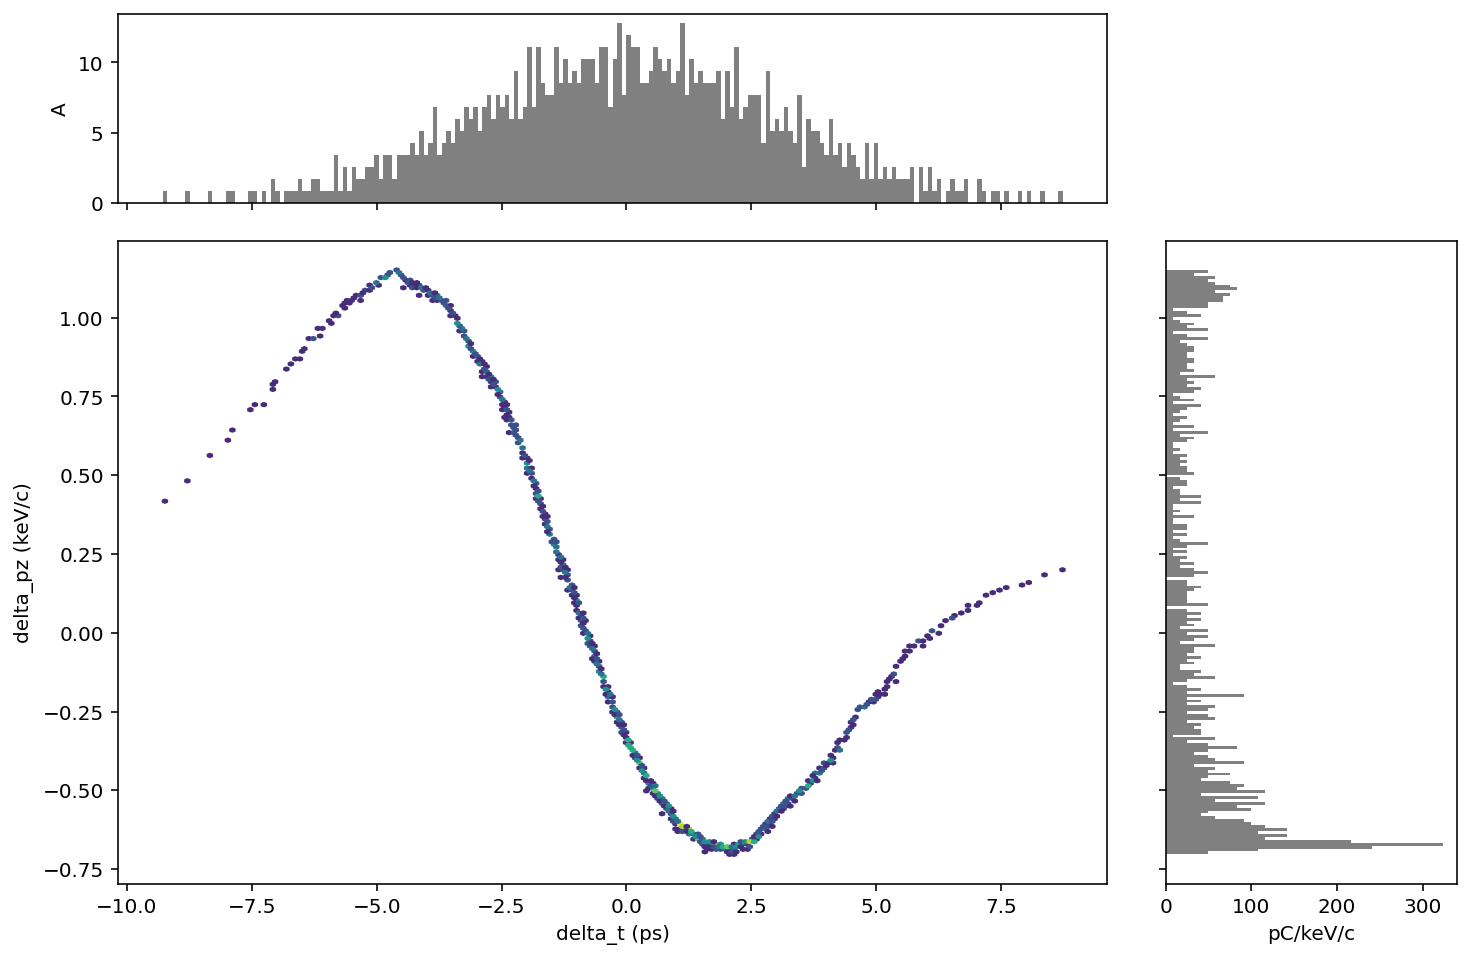

In [9]:
P = ParticleGroup(h5[ppaths[-1]])
P.plot('delta_t', 'delta_pz', bins=200)

In [10]:
os.remove(afile)

## evaluate examples

In [11]:
M.evaluate('lat::orbit.x[end]')

0.0

# csr_wake diagnostic file

In [12]:
from pytao.misc.csr import read_csr_wake_data_h5
import numpy as np

In [13]:
cdat = read_csr_wake_data_h5(h5, 'csr_wake')

In [14]:
cdat.keys()

dict_keys(['2:FF.PIP00B', '3:FF.BEN01', '4:FF.PIP01', '5:FF.BEN02', '6:FF.PIP02A'])

In [15]:
# This is the actual data
dat = cdat['3:FF.BEN01']['data']
dat.shape

(134, 40, 5)

In [16]:
dat = np.concatenate([cdat[key]['data'] for key in list(cdat) ])

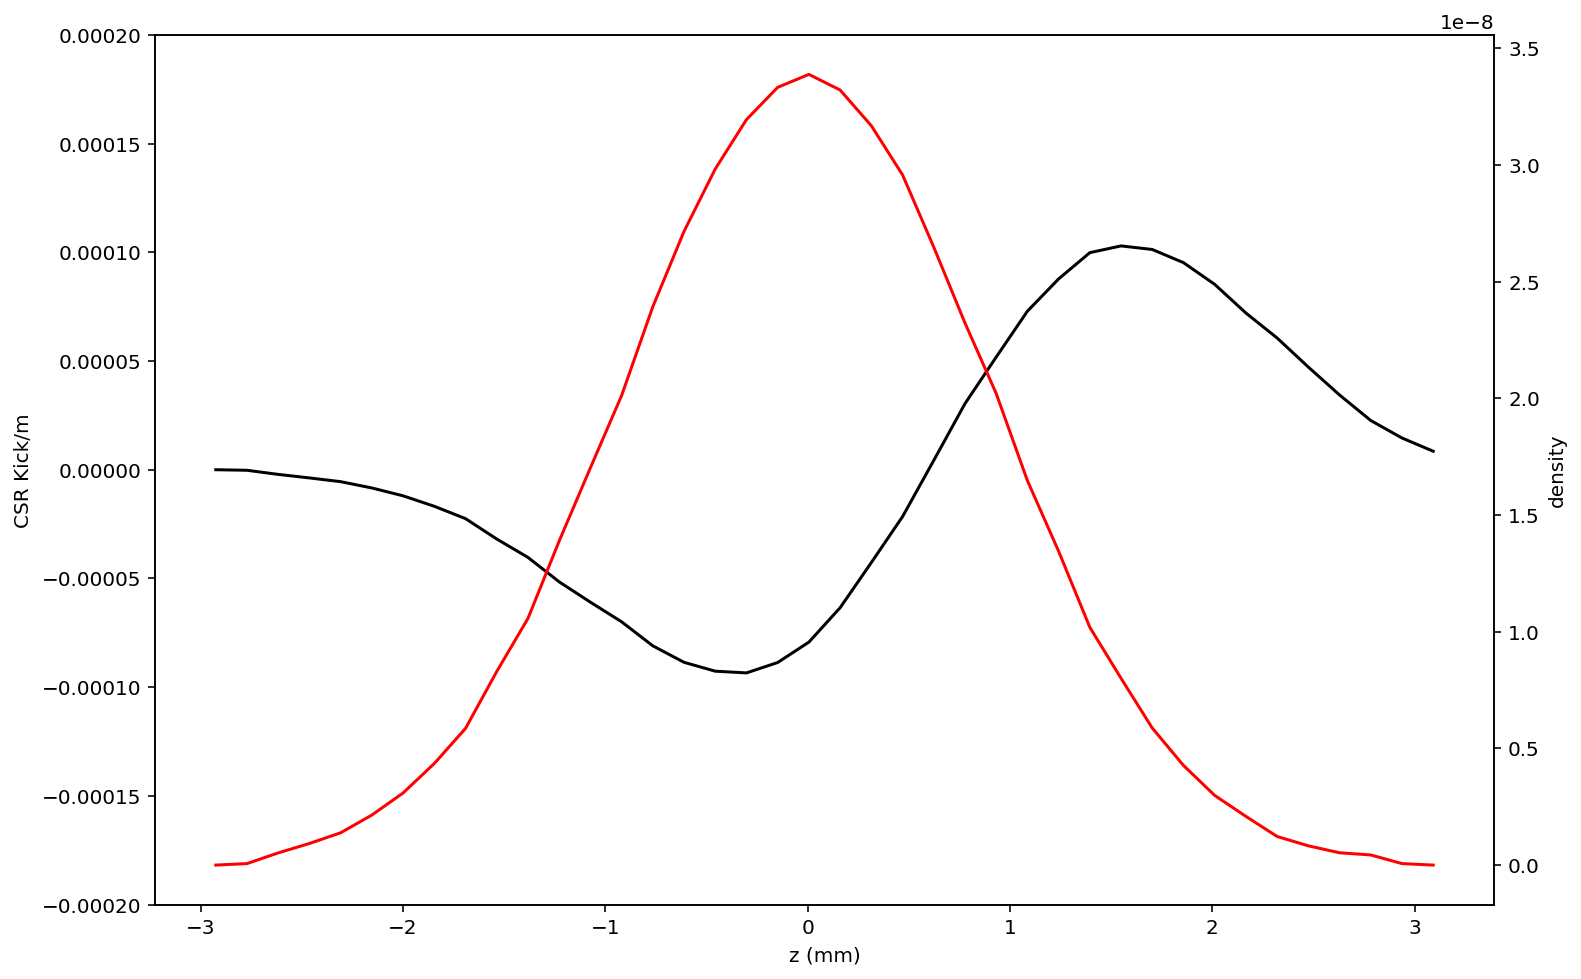

In [17]:
def plot1(step=0):
    
    fig, ax = plt.subplots()
    z = dat[step,:,0]*1e3
    ax.set_xlabel('z (mm)')
    ax.set_ylabel('CSR Kick/m')
    density =  dat[step,:,1]
    kick = dat[step,:,2]
    ax.plot(z, kick, color='black')
    
    ax.set_ylim(-.0002, .0002)
    ax2 = ax.twinx()
    ax2.set_ylabel('density')
    ax2.plot(z, density, color='red')
    
plot1(step=-1)

In [18]:
from ipywidgets import interact

interact(plot1, step=(0, len(dat)-1, 1) )

interactive(children=(IntSlider(value=0, description='step', max=449), Output()), _dom_classes=('widget-intera…

<function __main__.plot1(step=0)>